<html>
<div style="width:100%">
  <div style="width:90%; float:left; background:white; margin:10px">
    <img style ="width:100%"src ="https://raw.githubusercontent.com/publicunpublic/QCMM_Jupyter/main/full.svg">
    <div style="margin-top:2.5%;position:absolute;background-color:#0e4be5;width:6%;height:0.3%"></div>
  </div>
  </div>


<html>
<center>
<br>
<h1 style="color:#E6610F;"> Optimize TS or Intermediate from QCScan </h1>
<br><br>
</center>

In [1]:
import qcportal as ptl
import numpy as np
import pandas as pd

## Define Variables

In [14]:
client_address = "152.74.10.245:7778"
username = None
password = None
scan_collection_name = "salen-OMe_d-lac_i2_03_pbe0_def2-svp_36_48"
model_chem = "PBE0-D3BJ/def2-tzvp-Psi4"

In [15]:
client = ptl.FractalClient(address="152.74.10.245:7778", username = username, password = password, verify=False)

##  A)  Check the single point energies from the Scan

In [16]:
import warnings
warnings.filterwarnings("ignore")

ds = client.get_collection("Dataset",scan_collection_name )
ds.get_values(program='psi4')

,PBE0/def2-tzvp-Psi4,PBE0-D3BJ/def2-tzvp-Psi4
1.98,-1110032.488901,-1110081.987727
2.16,-1110033.033183,-1110082.654687
2.1,-1110032.783107,-1110082.402647
2.02,-1110032.536059,-1110082.119128
1.92,-1110032.435519,-1110081.830668
2.22,-1110033.255425,-1110082.853403
2.14,-1110032.95435,-1110082.576864
1.94,-1110032.421502,-1110081.833474
2.2,-1110033.187308,-1110082.796218
1.86,NaN,NaN


In [17]:
pd.set_option('display.max_rows', None)
ds.get_entries()

,name,molecule_id
0,1.98,45025
1,2.16,45005
2,2.1,45011
3,2.02,45020
4,1.92,45032
5,2.22,44999
6,2.14,45007
7,1.94,45030
8,2.2,45001
9,1.86,45040


##  B)  Plot the Scan trayectory

<IPython.core.display.Javascript object>


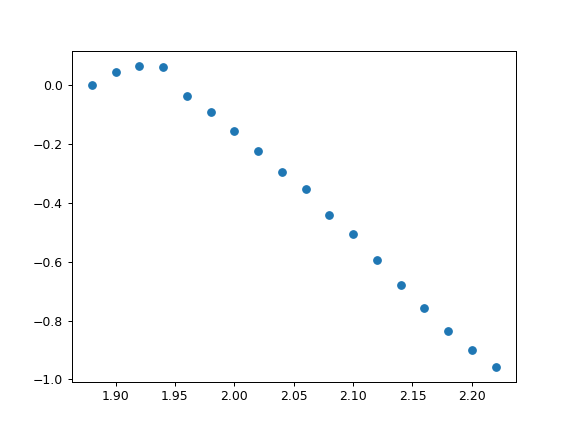

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook


model_chem = model_chem

scan_df = ds.df
scan_df = scan_df[scan_df[model_chem].notnull()]

init_energy = scan_df[model_chem].sort_index().iloc[0]
scan_df['rel_scan_energy'] = scan_df[model_chem] - init_energy
energy = scan_df['rel_scan_energy']
rx_coord =  [float(x) for x in scan_df.index]

plt.scatter(rx_coord, energy)

## C) Save scan in Molden format

In [7]:
opt_mol_id = ds.get_entries().molecule_id
opt_mol = client.query_molecules(list(opt_mol_id))

xyz_str = ''
for m in opt_mol:
    xyz_str += m.to_string("xyz")

filename = ds.name+'_anim.dat'
with open(filename, 'w') as handle:
    handle.write(xyz_str)

<html>
<center>
<br>
<h2> Send TS or Intermediate computation for best candidates </h2>
<br><br>
</center>

## Define variables

In [19]:
#int_candidate_id = 44962 
ts_candidate_id = 45030

entry_name = 'ts2_03'
name_from_scan = "salen-OMe_d-lac_ts"

## A)  Create OptimizationDataset and/or load TS/Intermediate candidate from NEB

In [20]:
# Creat or load OptDataset for the ts optimization 
#ds_opt = ptl.collections.OptimizationDataset(name_from_scan, client=client)
#ds_opt.save()
ds_opt = client.get_collection("OptimizationDataset", name_from_scan)
ds_opt.status(collapse=False)

,pbe0-d3_def2-svp
ts1_01,COMPLETE
ts1_03,COMPLETE
ts1_02,ERROR
ts1_04,INCOMPLETE
ts2_01,INCOMPLETE


## B) Load candidate molecule from server

In [21]:
mol = client.query_molecules(ts_candidate_id)[0]
mol

NGLWidget()

## C) Add molecule to OptimizationDataset collection

In [22]:
#Add entry to the TS/Interm OptimizationDataset

ds_opt.add_entry(entry_name, mol)
ds_opt.save()

'170'

In [ ]:
#Delete Specification

#del ds_opt.data.specs['b3lyp-d3_def2-svp']
#ds_opt.save()

In [103]:
#Delte Entry 

#del ds_opt.data.records['i1_03']
#ds_opt.save()

'179'

## D)  Add specification for TS/Int optmization with Terachem

This only needs to be done once but doing it again doesn't really hurt

#### For TS: 

In [79]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', 'dftgrid' : 2, "scf" : "diis+a"}})

kw_id = client.add_keywords([kw])[0]


add_spec = {'name':"b3lyp-d3_def2-svp",
        'description': 'Geometric + TERACHEM/b3lyp-d3/def2-svp.',
        'optimization_spec': {'program': 'geometric', 'keywords': {"transition": "yes", 
                                                                   "converge" :  ["set" , "gau_tight"]}},
        'qc_spec': {'driver': 'gradient',
        'method': "b3lyp",
        'basis': 'def2-svp',
        'keywords': kw_id,
        'program': 'terachem'}}
ds_opt.add_specification(**add_spec,overwrite=True)
ds_opt.save()

'93'

#### For Int: 

In [98]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', "scf" : "diis+a"}})

kw_id = client.add_keywords([kw])[0]


add_spec = {'name':"pbe0-d3_def2-svp",
        'description': 'Geometric + TERACHEM/pbe0-d3/def2-svp.',
        'optimization_spec': {'program': 'geometric', 'keywords': None},
        'qc_spec': {'driver': 'gradient',
        'method': "pbe0",
        'basis': 'def2-svp',
        'keywords': kw_id,
        'program': 'terachem'}}

ds_opt.add_specification(**add_spec,overwrite=True)
ds_opt.save()

'179'

## E)  Send computations to the queue

In [23]:
cr = ds_opt.compute(specification = 'pbe0-d3_def2-svp', tag='tera')#, subset=['HNO2', "HNO", 'HOCN', "N2O"])
cr

1

## F)  Check the status of the TS/Intermediate optimization

In [24]:
ds_opt = client.get_collection("OptimizationDataset", name_from_scan)
ds_opt.status(collapse = False)

,pbe0-d3_def2-svp
ts1_01,COMPLETE
ts1_03,COMPLETE
ts1_02,ERROR
ts1_04,INCOMPLETE
ts2_01,INCOMPLETE
ts2_03,INCOMPLETE


## G)  Check Optimzied Molecules

In [102]:
entry_name = "i1_03"
model_chem = "pbe0-d3_def2-svp"

rr = ds_opt.get_record(entry_name, specification = model_chem)
mol = rr.get_final_molecule()
mol

NGLWidget()

In [76]:
print(rr.get_stdout())

QCEngine selected.
174 internal coordinates being used (instead of 174 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 1-6
Distance 1-34
Distance 2-3
Distance 2-30
Distance 3-4
Distance 3-20
Distance 4-5
Distance 4-7
Distance 5-6
Distance 5-28
Distance 6-32
Distance 7-8
Distance 7-26
Distance 8-9
Distance 8-35
Distance 9-10
Distance 9-23
Distance 9-24
Distance 10-11
Distance 10-21
Distance 10-22
Distance 11-12
Distance 11-35
Distance 12-13
Distance 12-25
Distance 13-14
Distance 13-18
Distance 14-15
Distance 14-19
Distance 15-16
Distance 15-29
Distance 16-17
Distance 16-33
Distance 17-18
Distance 17-31
Distance 18-27
Distance 27-35
Distance 28-35
Distance 35-36
Distance 35-43
Distance 36-37
Distance 36-47
Distance 37-38
Distance 37-39
Distance 37-40
Distance 41-45
Distance 41-47
Distance 42-46
Distance 42-48
Distance 43-47
Distance 44-48
Distance 45-48
Distance 45-49
Distance 45-51
Distance 46-47
Distance 46-50
Distance 46-52
Distance 49-53
Distance

## Extras

### Restart jobs

In [ ]:
mol_list = []

spec = 'pbe0-d3_def2-svp'

for i in ds_opt.data.records: 
    #print(i)
    mol_list.append(i)

for i in  mol_list:
    opt_rec = ds_opt.get_record(name=i,specification= spec)
    if (opt_rec.status == 'ERROR'):    
        id_u = opt_rec.id 
        print('yes', i, id_u)
        c = client.modify_tasks("modify", new_tag = 'refinement_tera',base_result = id_u)
        #c = client.modify_tasks("restart",base_result = id_u)
        print(c)